## CAPSTONE - C964
### Joshua McCurry
Student ID 010629636

## ML DEMAND FORECASTING

Hello! Welcome to my ML Demand Forecasting notebook. The principle behind demand forecasting is simple; let's look at the historic demand for a range of items to predict how much we need in the future! This is something that supply chains in all industries do, and many different platforms perform this task. However, for years, I wondered what it'd look like to apply machine learning. So let's go!

In [35]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Capstone

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Capstone


### Step 1: Install dependencies.
- pandas = Data manipulation and analysis library
- scikit-learn = Machine learning library
- seaborn = Visualizations library
- itables = Dataframes enhancements
- pip list = Just shows a handy list of installed packages

In [36]:
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install itables
%pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
alembic                               1.16.5
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.8.1
arrow 

### STEP 2: Perform imports, instantiate our classes, and perform other minor initialization tasks.

In [37]:
import sys
sys.path.append('/Capstone/')
import pandas as pd
import numpy as np
import data_handler
import modeler
import predictor
import visualizer
from itables import init_notebook_mode, show

# Load the demand file
df = pd.read_csv('./demand_data.csv')

# Instantiate classes
dh = data_handler.data_handler()
md = modeler.modeler()
pred = predictor.predictor()
vis = visualizer.visualizer()

# Allows the itables dataframe to be interacted with
init_notebook_mode(all_interactive=True)

### Step 3: Load the data!

Here we get a first look at our historic demand. The intervals in which organizations capture their demand can vary depending on the "velocity" of that item. The demand dates for this dataset also differ from item to item. Some items have daily or near-daily demand, while others have a gap of weeks or more. This demand data usually consists of a big pile of items, the date of the demand, and the quantity of that demand at a minimum.

In [38]:
# Load the data
df = dh.load_data()
show(df, maxBytes=0)

Getting demand
Data Loaded


Loading ITables v2.5.2 from the internet... (need help?)


### Step 4: Clean and trim the Data
This step removes null values, rows with zero demand, performs a sort by "Demand Date", and provides an informative printout.

In [39]:
# Send the data through the washing machine
df = dh.clean_data(df)
df = dh.trim_demand(df, 5)
show(df, maxBytes=0)

Dirty Row Count: 5313
Clean Row Count: 4488
The most recent date found is 2025-09-16.
Data beginning at 2020-09-16 will be kept.
Trimmed Row Count: 4020


Loading ITables v2.5.2 from the internet... (need help?)


### Step 5: Featurize the Data
This is an important step. The bulk of the work is turning our "Demand Date" column into a datetime object, then breaking it out into some different units of time. I discovered quickly that linear regression models don't appreciate a traditional date, so it creates a "time_index" that is used instead. It then provides these back as a list of features.

In [40]:
features = dh.data_wrangler(df)
print(features)

['Warehouse', 'Item', 'time_index', 'year', 'month', 'day_of_week', 'week_of_year']


### Step 6: Split our Data
We have to split our data into a training set and a testing set. This allows us to train the linear regression model on the bulk of the data, then make predictions with the testing data it hasn't seen. This is hard-coded to an 80:20 train-to-test split, but would be easy to turn into a user-defined option.

In [41]:
X_train, X_test, y_train, y_test = md.split_data(df, features)

### Step 7: Train the Model!
Here, we will train our model using the training data we split out in step 7.

In [42]:
# Train a model for Original Demand
model = md.train_model(X_train, y_train)

### Step 8: Make Some Predictions!
Now we invoke our trained model and pass it the independent variables from our testing data that we set aside earlier. The model makes predictions on data it hasn't seen based on what it's expecting from the data it has seen. Because the predictions method only provides back a list of its predictions, we have to combine our independent variables, dependent variables, and predictions to a single dataframe.

In [43]:
# Make predictions with the model
y_pred = pred.crystal_ball(model, X_test)
show(X_test, maxBytes=0)

# Combine our independent variables, dependent variables, and the predictions.
results = dh.prep_results(X_test, y_test, y_pred)
show(results, maxBytes=0)

Loading ITables v2.5.2 from the internet... (need help?)


Loading ITables v2.5.2 from the internet... (need help?)


### Step 9: Score the Model Results
I'm using the Mean Average Percentage Error (MAPE) to score the model's deviation from the actual demand values in its predictions. I first calculate the Average Percentage Error, the obtain the average across all of the predictions to get the MAPE.

In [44]:
# Get the APE
results['MAPE'] = np.abs((results['Actual Demand'] - results['Predicted Demand']) / results['Actual Demand'])

# Get the Mean
sum_mape = results['MAPE'].sum()
row_count = len(results['MAPE'])
mape = sum_mape // row_count
print(f"MAPE Score: {mape}")

MAPE Score: 4.0


#### We will get some insight into this score in the last visualization.

### Step 10: Export the Results
This step exports our results to a CSV named "demand_predictions.csv".

In [45]:
# Export to CSV
sorted_results = dh.sort_results(results)
dh.export_results(sorted_results)

### Step 11: Overall Demand Histogram
This is a visually interesting chart that shows our overall demand. You can clearly see 2024 was a banner year for these items in particular, and 2025 is lagging behind a bit, but it is still competitive.

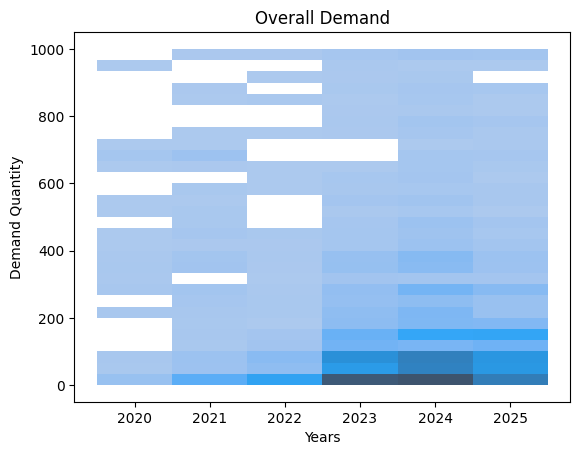

In [46]:
# Creates the overall data histogram
overall_df = dh.overall_hist_prep(df)
vis.better_hist(overall_df)

### Step 12: Overall Demand Line Chart
Next, we're going to see this same demand data summed over the course of the year for each item. Given the number of items and the nature of the chart, this has been split into two separate charts telling similar stories. We can quickly identify the items that all contributed significantly to the performance of 2024 compared to their peers. We can also see it's dropped since.

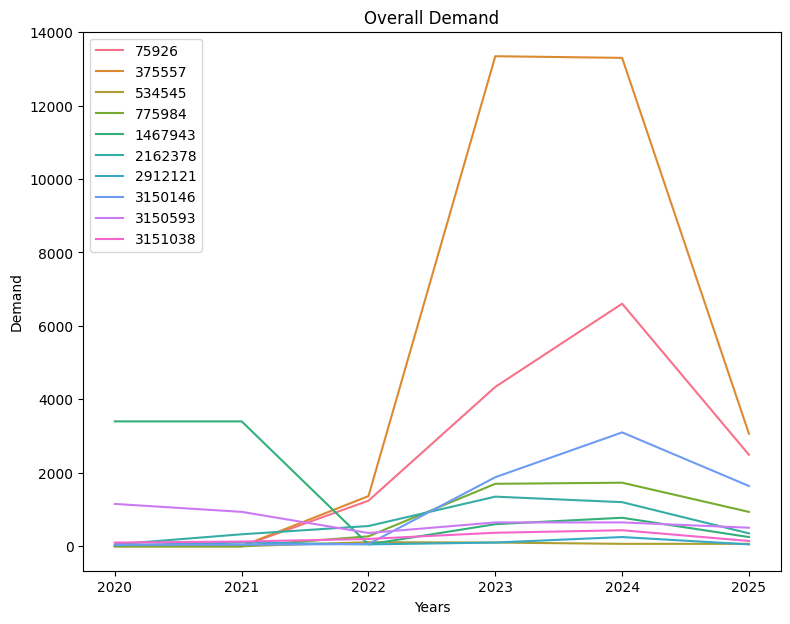

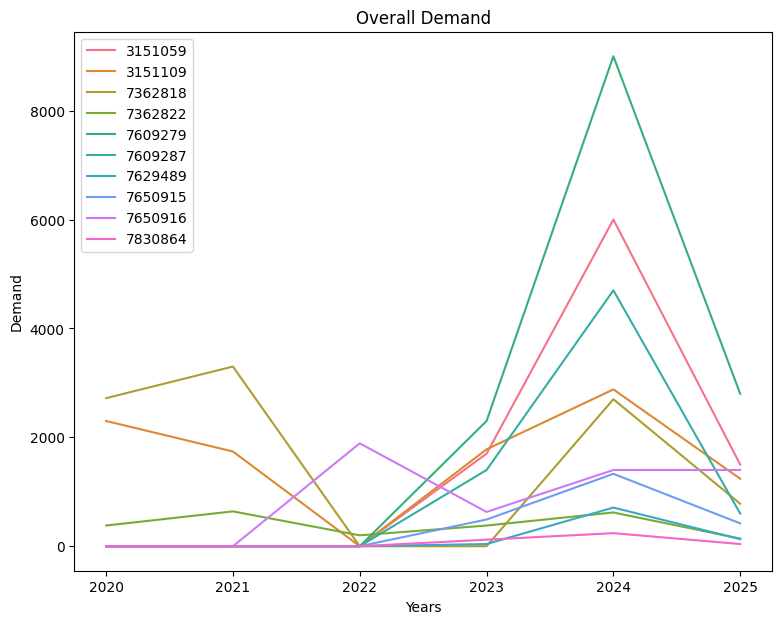

In [47]:
# Create two line charts from the results
# All 20 items in one line chart is uninterpretable
res_wide = dh.pred_results_wide(results)
# Get the center of the columns
midpt = len(res_wide.columns) // 2
# Select everything to the left, then right of the midpoint, respectively
res_wide_pt1 = res_wide.iloc[:, :midpt]
res_wide_pt2 = res_wide.iloc[:, midpt:]
vis.lineplot(res_wide_pt1)
vis.lineplot(res_wide_pt2)

### Step 13: Heatmap of Item Demand Over Time
This is another effective visualization that illustrates how the demand quantities of specific items compare to one another.

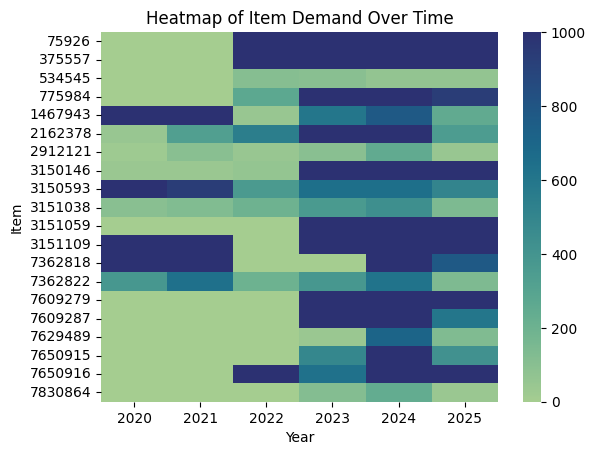

In [48]:
# Create a heatmap of demand
heat_df = dh.heat_prep(results)
vis.heatmap(heat_df)

### Step 14: A Bar Chart of Absolute Percentage Error Scores
Here, we can see some major offenders that are dragging the MAPE score down, as we saw earlier. In particular, items 3151038, 534545, 7629489, and 775984 are causing the most damage. The dark lines at the top of each bar display the relative confidence of the score.

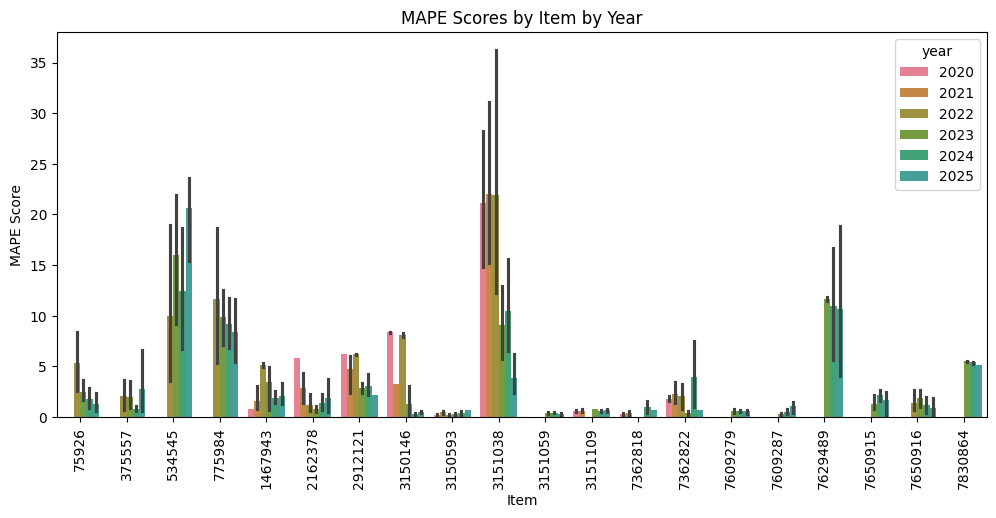

In [49]:
# Create a barchart of the overall MAPE score
mape_vis = dh.mape_prep(results)
vis.mape(mape_vis)

### Step 15: Let's Use It!
Now that we have trained the model, tested it against data it hasn't seen, and quantified the results and its performance, it's time to make an actual set of predictions. Here, we will load a demand forecast file with a "Demand Date" in the future (10/1/25), which will not have the dependent variable (Demand Quantity) for us to compare against.

In [50]:
pred_df = dh.load_forecast()
show(pred_df, maxBytes=0)

Getting Forecast File
Forecast Loaded


Loading ITables v2.5.2 from the internet... (need help?)


### Step 16: Prep the Data
Just as before, we're going to prepare this simple dataset for the model.

*NOTE: We're not going to run the dataframe through the trim method since we're making a prediction.*

In [51]:
# Send the data through the washing machine, featurize it, then prepare the independent variables dataframe
pred_df = dh.clean_data(pred_df)
pred_feat = dh.data_wrangler(pred_df)
pred_df = md.featurize(pred_df, pred_feat)

show(pred_df, maxBytes=0)

Dirty Row Count: 804
Clean Row Count: 20


Loading ITables v2.5.2 from the internet... (need help?)


### Step 17: Make a Prediction
Finally, we get to make some actual predictions. The catch is, we only have clues from the above that can help inform us of how accurate these predictions are. Items 3150146, 3150593, 3151059, 3151109, 1362818, 7609279, and 7609287 are likely to be the best performing.

In [52]:
# Make predictions with the model
our_pred = pred.crystal_ball(model, pred_df)
outcome = dh.prep_pred(pred_df, our_pred)
show(outcome, maxBytes=0)

Loading ITables v2.5.2 from the internet... (need help?)


### Conclusions
I learned so much doing this task. Here, I'm only using linear regression, but there really is a broad range of "features" in the systems that host sales data and other models with unique strengths that could work together to make for impressive results. The bottom line is I finally got to explore this long-standing idea of mine, and I believe it could be viable. Some notes:
- Models trained per item might perform significantly better than those trained across many items for more precise by-item demand.
- Item units of measure can wreak havoc. Some item orders are in the tens or hundreds, while others can be in the tens or hundreds of thousands. This supports the one-model-per-item notion.
- Items with similar units of measure, ordering quantities, and ordering patterns may not suffer from being grouped. Above the items with the lowest APE scores might all be candidates.
- Linear regression models are not ideal for items with seasonality or wild demand swings.